In [1]:
import os
os.chdir(os.path.expanduser("~/work/nbs_pipeline"))

In [2]:
#| export
verbose                       = 0
check_memory_usage            = True
time_flag                     = True
window_size_percentage        = True
show_plots                    = True
reset_kernel                  = True
pre_configured_case           = True
case_id                       = 7
frequency_factor              = 1
frequency_factor_change_alias = True
check_parameters              = True
cuda_device                   = 0
remove_lambdas_flag           = True

MOIRAI: Toy complete execution

In [3]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download

from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
import sys
import dvats.utils as ut
import torch
import matplotlib.pyplot as plt
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download

import uni2ts
from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.eval_util.plot import plot_next_multi
import pyarrow.feather as ft
from gluonts.transform.split import TFTInstanceSplitter
from gluonts.transform.sampler import TestSplitSampler
import numpy as np
import einops
import torch.nn.functional as F
from dvats.memory import gpu_memory_status

In [4]:
#| export
device = torch.device(f'cuda:{cuda_device}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    gpu_memory_status(gpu_device)

GPU | Used mem: 11
GPU | Used mem: 24
GPU | Memory Usage: [█████████-----------] 46%


In [5]:
import dvats.config as cfg_

In [6]:
#| export
import warnings
warnings.filterwarnings("ignore", module="umap")
import os
import sys
sys.path.append(os.path.abspath('..'))
from dvats.all import *
from fastcore.all import *
from tsai.basics import *
from tsai.models.InceptionTimePlus import *
from tsai.callback.MVP import *
import matplotlib.colors as colors
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.schedule import *
from fastai.callback.tracker import EarlyStoppingCallback
import wandb
from momentfm import MOMENTPipeline
import torch
import matplotlib.pyplot as plt
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download

from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.eval_util.plot import plot_next_multi

<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.IpcWriteOptions size changed, may indicate binary incompatibility. Expected 72 from C header, got 88 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.IpcReadOptions size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.Tensor size changed, may indicate binary incompatibility. Expected 64 from C header, got 80 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.NativeFile size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.BufferedInputStream size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.BufferedOutputStream size changed, may indicate binary 


Octave is ready <oct2py.core.Oct2Py object at 0x7f3d025cfd90>

















In [7]:
#| export
user, project, version, data, config, job_type = cfg_.get_artifact_config_MVP(False)
if pre_configured_case: 
    cfg_.force_artifact_config_mvp(
        config = config,
        id = case_id,
        verbose = verbose, 
        both = verbose > 0,
        frequency_factor = frequency_factor,
        frequency_factor_change_alias = frequency_factor_change_alias
    )

In [8]:
#| export
path = os.path.expanduser("~/work/nbs_pipeline/")
name="02c_encoder_moment-embedding"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
if verbose > 0: print("runname: "+runname)
if verbose > 0: cfg_.show_attrdict(config)

In [9]:
#| export
if verbose > 0: print("--> Wandb init")
run = wandb.init(
    entity = user,
    # work-nbs is a place to log draft runs
    project=project,
    group=config.wandb_group,
    job_type=job_type,
    allow_val_change=True,
    mode=config.analysis_mode,
    config=config,
    # When use_wandb is false the run is not linked to a personal account
    #NOTE: This is not working right now
    anonymous = 'never' if config.use_wandb else 'must', 
    resume=False,
    name = runname
)
if verbose > 0: print("Wandb init -->")
config = run.config  # Object for storing hyperparameters
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /home/macu/work/nbs_pipeline/02c_encoder_moment-embedding.ipynb.
wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


In [10]:
#| export
config = run.config  # Object for storing hyperparameters
if verbose > 0: cfg_.show_attrdict(config)
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact
train_artifact = artifacts_gettr(config.train_artifact)
if verbose > 0: print("---> W&B Train Artifact")

In [11]:
#| export
import pyarrow.feather as ft
df_train = train_artifact.to_df()
df_train.shape

wandb:   1 of 1 files downloaded.  


(550, 3)

In [12]:
print(df_train.shape)
display(df_train.head())

(550, 3)


,T3,T2,T1
1970-01-01 00:00:00,0.741822,0.637180,0.565117
1970-01-01 00:00:01,0.739731,0.629415,0.493513
1970-01-01 00:00:02,0.718757,0.539220,0.469350
1970-01-01 00:00:03,0.730169,0.577670,0.444100
1970-01-01 00:00:04,0.752406,0.570180,0.373008


In [13]:
#| export
if verbose > 0: print("---> Sliding window | ", config.w,  " | ", config.stride )
sw = SlidingWindow(window_len=config.w, stride=config.stride, get_y=[])
if verbose > 0: print(" Sliding window | ", config.w,  " | ", config.stride, "---> | df_train ~ ", df_train.shape )
X_train, _ = sw(df_train)
if verbose > 0: print(" sw_df_train | ", config.w,  " | ", config.stride, "--->" )

In [14]:
# n_win x n_vars x win_size
# n_batches x n_features x patch_size (before padding)
X_train.shape

(521, 3, 30)

In [15]:
embs = get_enc_embs(
    X          = X_train, 
    enc_learn = MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-small"),
    cpu       = False,
    average_seq_dim = True,
    to_numpy        = True,
    verbose         = 1,
    patch_size      = 8,
    size            = "small",
    time            = True
)

config.json:   0%|          | 0.00/682 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/55.3M [00:00<?, ?B/s]

--> get_enc_embs_moirai
get_enc_embs_moirai | Using CUDA
get_enc_embs_moirai | Get Outputs
--> get_enc_embs_moirai | past_target ~ torch.Size([521, 30, 3])
--> get_enc_embs_moirai | past_observed_target ~ torch.Size([521, 30, 3])
--> get_enc_embs_moirai | past_is_pad ~ torch.Size([521, 30])
--> get_enc_embs_moirai | Auxiliar model
--> get_enc_embs_moirai | Convert sizes
--> get_enc_embs_moirai | target ~ torch.Size([521, 15, 128])
--> get_enc_embs_moirai | observed_mask ~ torch.Size([521, 15, 128])
--> get_enc_embs_moirai | sample_id ~ torch.Size([521, 15])
--> get_enc_embs_moirai | time_id ~ torch.Size([521, 15])
--> get_enc_embs_moirai | variate_id ~ torch.Size([521, 15])
--> get_enc_embs_moirai | prediction_mask ~ torch.Size([521, 15])
get_enc_embs_moirai | embs ~ embs.shape
get_enc_embs_moirai -->


In [16]:
embs.shape

(521, 384)

In [17]:
# Reduction for execution time 
#X_train = X_train[:3, :, :]
X_train.shape

(521, 3, 30)

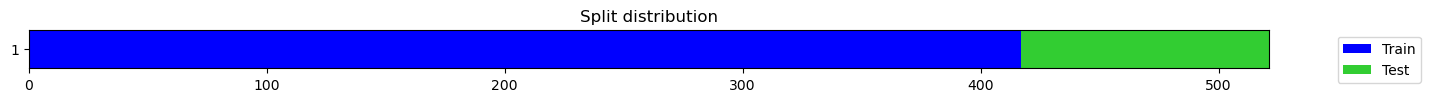

In [18]:
assert config.analysis_mode in ['offline','online'], 'Invalid analysis mode'

X = X_train
if verbose > 0: print("len(X): ", len(X));
if config.analysis_mode == 'online':
    if verbose > 0: print("--> Split 1")
    splits = TimeSplitter(valid_size=0.2, show_plot=show_plots)(X)
elif config.analysis_mode == 'offline':
    if verbose > 0: print("--> Split 2")
    splits = get_splits(np.arange(len(X)), valid_size=config.valid_size, show_plot = show_plots)
if verbose > 0: 
    print("Split -->", len(splits[0]))

In [19]:
#| hide
if verbose > 0: 
    print(X.shape)
    display(splits)
    

In [20]:
len(splits)
len(splits[0])

417

In [21]:
X_train.shape

(521, 3, 30)

Ñapa para ver si es un problema de tamaños o qué (dejar 1 ventana solo como en el  ejemplo de uso)

In [22]:
#X_train = X_train[0]
#X_train = einops.rearrange(  torch.as_tensor(X_train, dtype = torch.float32), "... -> 1 ...")
#X_train.shape

Hasta aquí la ñapa

In [23]:
past_target = einops.rearrange(
    torch.as_tensor(X_train, dtype = torch.float32),
    "n_windows n_vars window_size -> n_windows window_size n_vars"
)
# 1s if the value is observed, 0s otherwise. Shape: (batch, time, variate)
past_observed_target = torch.ones_like(past_target, dtype=torch.bool)
# 1s if the value is padding, 0s otherwise. Shape: (batch, time)
past_is_pad = torch.zeros_like(past_target, dtype=torch.bool)[...,:,-1] # Kill last dimension

In [24]:
print(past_target.shape)
print(past_observed_target.shape)
print(past_is_pad.shape)

torch.Size([521, 30, 3])
torch.Size([521, 30, 3])
torch.Size([521, 30])


In [25]:
#patch_size = 32 -> ok
patch_size = 8

In [26]:
observed_mask = torch.ones_like(past_target, dtype = bool)


¿ Pero tiene sentido separar en Train y test en un zero - shot ? 
Cojámoslo entero
Y cojamos todo como input en lugar de input y label

In [27]:
module = MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-small")

In [28]:
# Auxiliar model for conversions just to ensure correct sizes
forecast_model =  MoiraiForecast(
    module=module,
    prediction_length=past_target.shape[2], #random, just for getting the model
    context_length=past_target.shape[1],
    patch_size=patch_size,
    num_samples=100, #Random, is the number of forecasting, not interesting for us
    target_dim=past_target.shape[2],
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)

In [29]:
forecast = forecast_model(
    past_target=past_target,
    past_observed_target=past_observed_target,
    past_is_pad=past_is_pad,
)

In [30]:
(
    target,
    observed_mask,
    sample_id,
    time_id,
    variate_id,
    prediction_mask,
) = forecast_model._convert(
    patch_size,
    past_target,
    past_observed_target,
    past_is_pad
)

In [31]:
from fastai.callback.hook import *

from tsai.models.layers import *

def get_acts(
    model, 
    modules, 
    y=None, 
    detach=True, 
    cpu=False,
    attr_name = "data",
    verbose = 0,
    **model_kwargs
):
    r"""Returns activations and gradients for given modules in a model and a single input or a batch. 
    Gradients require y value(s). If they are not provided, it will use the predictions. """
    if not isinstance(modules, list): modules = [modules]
    if ('x' in model_kwargs):
        x = x[None, None] if x.ndim == 1 else x[None] if x.ndim == 2 else x
    if cpu: 
        model = model.cpu()
        #x = x.cpu()
        for key in model_kwargs:
            try: #if not able to be moved, just not move it
                model_kwargs[key] = model_kwargs[key].cpu()
            except:
                continue
    with hook_outputs(modules, detach=detach, cpu=cpu) as h_act:
        if verbose > 0:
            print("get_acts | hook outputs | h_act")
        preds = model.eval()(**model_kwargs)
    
    if len(modules) == 1: 
        if verbose > 1:
            print(f"get_acts | h_act stored ~ ", len(h_act.stored))
            print(f"get_acts | h_act stored: ", h_act.stored)
        #try:
        res = getattr(h_act.stored[0], attr_name), getattr(h_act.stored[0][0], attr_name)
        #except:
            #res = getattr(h_act.stored[0][0], attr_name), getattr(h_act.stored[0][0][0], attr_name)
        return res
    else: 
        return [h.data for h in h_act.stored], [getattr(h_act.stored[0], attr_name) for h in h_grad.stored]

In [32]:
model_kwargs={
    'target': target, 
    'observed_mask': observed_mask,
    'sample_id': sample_id,
    'time_id': time_id,
    'variate_id': variate_id,
    'prediction_mask': prediction_mask,
    'patch_size': torch.ones_like(sample_id, dtype = torch.float32)*patch_size
} 

In [33]:
forecast_model_kwargs={
    'past_target': past_target, 
    'past_observed_target': past_observed_target,
    'past_is_pad': past_is_pad
} 

Pequeño trial porque se queda bloqueado y no entiendo por qué


In [34]:
#predictor = forecast_model.create_predictor(batch_size = target.shape[0])
#forecasts = predictor.predict(target)

Fin del trial

In [35]:
from dvats.utils import Time

In [36]:
def get_module_activation(model, module, cpu, **model_kwargs):
    if cpu:
        for key in model_kwargs:
            try: #if not able to be moved, just not move it
                model_kwargs[key] = model_kwargs[key].cpu()
            except:
                continue
    h_act = hook_outputs([module], detach = True, cpu = cpu, grad = False)
    preds = model.eval()(**model_kwargs)
    return [o.stored for o in h_act]

In [37]:
type(module.encoder.norm)

uni2ts.module.norm.RMSNorm

In [38]:
? uni2ts.module.norm.RMSNorm

Init signature:
 uni2ts.module.norm.RMSNorm(
    normalized_shape: int | list[int] | torch.Size,
    eps: float = 1e-05,
    weight: bool = True,
    dtype: Optional[torch.dtype] = None,
)
Docstring:     
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 20, 5)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            return F.relu(self.conv2(x))

Submodules assigned in this way will be registered, and will have their
parameters converted too when you call :meth:`to`, etc.

.. note::
    As per the example above, an ``__init__()`` call to the parent class
   

In [39]:
timer = Time()
modules = [module.encoder.norm]
timer.start()
acts = get_module_activation(
    model = module, 
    module = module.encoder.norm, 
    cpu = False, 
    **model_kwargs
)
timer.end()
timer.show()


[] Start: 1728556330.0303416 | End: 1728556343.7221625 | Duration: 13.691820859909058 seconds


13.691820859909058

In [40]:
embs = acts[0]
embs.shape

torch.Size([521, 15, 384])

In [41]:
embs = embs.mean(dim = 1)
embs.shape

torch.Size([521, 384])

In [42]:
type(module)

uni2ts.model.moirai.module.MoiraiModule